In [ ]:
import torch
import torchvision

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform, train=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform, train=False)

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
resnet = torchvision.models.resnet18()
resnet.fc = torch.nn.LazyLinear(10)
r = resnet.cuda()

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

In [ ]:
optim = torch.optim.Adam(resnet.parameters())

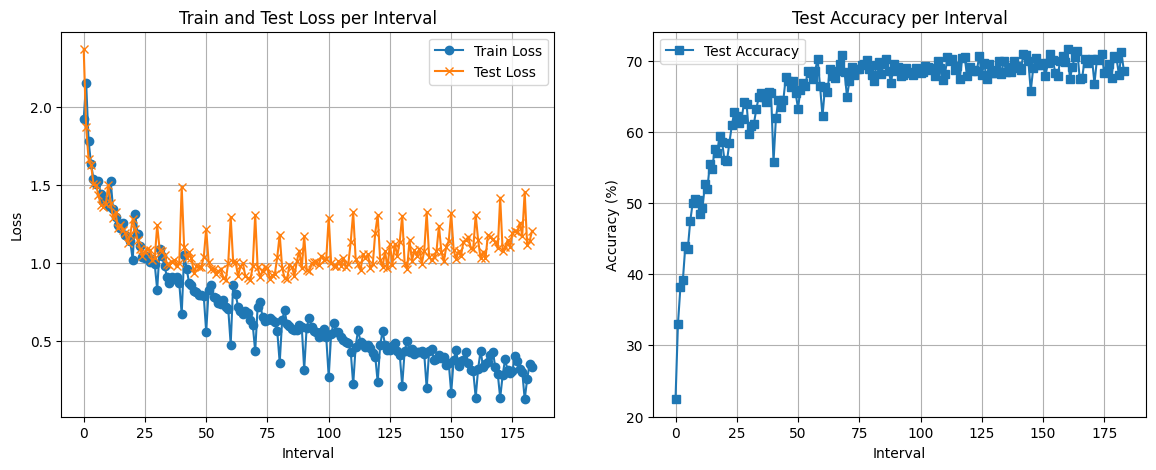

Epoch 19/10:  39%|███▉      | 77/196 [00:18<00:53,  2.21it/s]

Epoch [19/10], Interval [76], Train Loss: 0.3330, Test Loss: 1.2069, Test Accuracy: 68.56%


Epoch 19/10:  47%|████▋     | 93/196 [00:19<00:10,  9.59it/s]

In [ ]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm


def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return avg_loss, accuracy

# Setup
train_losses, test_losses, test_accuracies = [], [], []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)

interval = len(train_dataloader) // 10

for ep in range(100):
    resnet.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_dataloader, desc=f'Epoch {ep+1}/10'), 1):
        data, target = data.to(device), target.to(device)

        optim.zero_grad()
        output = resnet(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optim.step()

        running_loss += loss.item()

        if batch_idx % interval == 0:
            avg_train_loss = running_loss / interval
            train_losses.append(avg_train_loss)
            running_loss = 0.0

            # Evaluate on test set
            test_loss, test_accuracy = evaluate_model(resnet, test_dataloader, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            # Plot Loss and Accuracy
            clear_output(wait=True)
            plt.figure(figsize=(14,5))

            plt.subplot(1,2,1)
            plt.plot(train_losses, marker='o', label='Train Loss')
            plt.plot(test_losses, marker='x', label='Test Loss')
            plt.xlabel('Interval')
            plt.ylabel('Loss')
            plt.title('Train and Test Loss per Interval')
            plt.legend()
            plt.grid(True)

            plt.subplot(1,2,2)
            plt.plot(test_accuracies, marker='s', label='Test Accuracy')
            plt.xlabel('Interval')
            plt.ylabel('Accuracy (%)')
            plt.title('Test Accuracy per Interval')
            plt.legend()
            plt.grid(True)

            plt.show()

            print(f'Epoch [{ep+1}/10], Interval [{batch_idx}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

